# Upwelling analysis

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import os
import gsw
from contextlib import ExitStack
from cmocean import cm
from matplotlib import cm as matcm
from matplotlib import colors
from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.interpolate import griddata
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools
from dynmodes import dynmodes

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

## Processing code

### Define variables and load reference datasets

In [3]:
# Load mask and bathymetry
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

with open('parameters.yaml') as f:
    grids, _, events = yaml.safe_load_all(f)
    
const = {
    'g': 9.81, 'f': 1.11e-4, 'N': 0.01, 'h_s': 10, 'H': 50, 'L_r': 2e4, 't': 86400,
    'rho_0': 1025, 'rho_s': 1020, 'rho_air': 1.23, 'C_d': 1e-3,
}

params = {
    'u_wind': [5, 10, 15],
    'h_s': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
    'N': np.arange(0.01, 0.026, 0.0025),
}

***

### Calculate coastline indices

In [4]:
def calc_coastline_indices(filter_window=5, e1t_0=500):
    """Find the NEMO-SalishSeaCast j, i pairs along the western coastline.                                      
    Also finds the coastline angle CW from north-south, and the average cross-                                  
    shore bottom slope between zero and 200 m depth. I would prefer this                                        
    routine to be flexible to various choices of jmin, jmax and jsub but in                                     
    reality it takes a bit of tuning to avoid errors.                                                           
    """

    # Mask out Gulf Islands
    tmask = mask.tmask[0, ...].values
    tmask[:, :450, :230] = 0
    
    # Indexing parameters
    imin, jmin, jmax, jsub = 115, 355, 730, 5
    jignore = [365, 370, 430, 460, 485, 490, 515, 595, 600, 615, 635, 640, 645, 650]
    
    # Create jindex
    jcoast = np.arange(jmin, jmax, jsub)
    jignore = np.array([j in jignore for j in jcoast])
    jcoast = jcoast[~jignore]
    
    # Build angle array (angles and ranges were chosen manually)
    jcut = [0, 360, 405, 425, 460, 555, 570, 600, 650, 695, 897]
    angles = [-0.55, -0.35, -0.2, -0.1, -0.6, -0.45, -0.25, -0.3, -0.25, -0.1]
    angle = np.zeros(len(jcoast))
    for j0, j1, a in zip(jcut[:-1], jcut[1:], angles):
        angle[(jcoast > j0) & (jcoast <= j1)] = a

    # Initialize index array                                                   
    icoast, iwind, jwind, slope = [], [], [], []
    d = int(const['L_r'] / e1t_0)

    # Iterate through jindex                                                                                    
    for j, a in zip(jcoast, angle):

        # Find i at coast                                                                    
        i, i_d = [np.where(abs(np.diff(tmask[z, j, imin:])) > 0)[0] for z in [0, 29]]                                                                  
        i = i[i < i_d[0]][-1] + imin
        
        # Define offshore sections
        i_s = np.linspace(i, i + np.cos(a) * d, d).astype(int)
        j_s = np.linspace(j, j - np.sin(a) * d, d).astype(int)
        
        # Find j, i of deep isobath (or slightly shallower if necessary) and slope
        e1t, e2t = [mask_arrays[key][j, i] for key in ['e1t', 'e2t']]
        index = np.array([float(bathy.Bathymetry[y, x]) for y, x in zip(j_s, i_s)]) > const['H']
        index = index.nonzero()[0][0]
        j_d, i_d = j_s[index], i_s[index]
        s = const['H'] / np.sqrt(((i_d - i) * e1t)**2 + ((j_d - j) * e2t)**2)
        
        # Search for nearest lon/lat neighbors
        j_w, i_w = geo_tools.find_closest_model_point(
            mask.glamt[0, j, i].values, mask.gphit[0, j, i].values,
            grid_HRDPS.longitude-360, grid_HRDPS.latitude,
            grid='GEM2.5', tols={'GEM2.5': {'tol_lon': 0.017, 'tol_lat': 0.017}},
        )
        
        # Append new values
        icoast.append(i)
        iwind.append(i_w)
        jwind.append(j_w)
        slope.append(s)

    # Populate sections dict
    window = signal.get_window('blackman', filter_window)
    w = int((filter_window - 1) / 2)
    subset = slice(w, -w)
    sections = {
        'ji': [jcoast[subset], np.array(icoast)[subset]],
        'ji_wind': [np.array(jwind)[subset], np.array(iwind)[subset]],
        'angle': np.array(angle)[subset], 'n': len(jcoast[subset]),
        'slope': signal.convolve(slope, window / sum(window), mode='same')[subset],
    }

    return sections

***

### Process results

Universal functions

In [5]:
def calc_rho(data, depth, tmask):
    """
    """

    # Calculate density
    tracers = ['vosaline', 'votemper']
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[key]) for key in tracers], depth)

    return rho

Idealized result functions

In [6]:
def calc_idealized_metrics(runs, file, param, hour=24, ji_0=(500, 240)):
    """
    """
    
    # Define pointer variables and list storage
    ones = np.ones(sections['n'])
    deptht, tmask = [mask_arrays[key] for key in ['gdept_1d', 'tmask']]
    i_sub, _, j_sub, _ = grids['ideal']
    
    # Append coast parameters
    values = [sections['ji'][0], sections['angle'], sections['slope']]
    for key, val in zip(['j', 'angle', 'slope'], values):
        runs[key] = np.hstack((runs[key], val))
    
    # Calculate wind stress
    tau = param['U']**2 * const['rho_air'] * const['C_d']
    for key, func in zip(['tau_along', 'tau_cross'], ['sin', 'cos']):
        runs[key] = np.hstack((runs[key], tau * getattr(np, func)(np.arctan(2) - sections['angle'])))
    
    # Open results file
    with xr.open_dataset(file) as data:
        
        # Calc t_0 density parameters
        j, i = ji_0
        rho_t0 = calc_rho(data.isel(time_counter=0, y=j-j_sub, x=i-i_sub), deptht, tmask[:, j, i])
        rho_pyc = rho_t0[int(abs(deptht - param['h_s']).argmin()) + 1]
        
        # Calc N if not provided
        if 'N' not in param:
            depthw, e3t = [mask_arrays[key] for key in ['gdepw_1d', 'e3t_1d']]
            z_b = abs(deptht - const['H']).argmin()
            param['N'] = (e3t[:z_b] * np.sqrt(data.buoy_n2[0, :z_b, j-j_sub, i-i_sub].values)).sum() / depthw[z_b]

        # Loop through sections
        for j, i, a in zip(*sections['ji'], sections['angle']):
            
            # Calculate rho at hour
            L, rho = int(const['L_r'] / mask_arrays['e1t'][j, i]), []
            rho = calc_rho(
                data.isel(time_counter=hour, deptht=0, y=j-j_sub, x=slice(i-i_sub, i-i_sub+L)),
                0, tmask[0, j, i:i+L],
            )
            
            # Calculate upwelling depth and offshore pycnocline displacement
            runs['h_u'].append(deptht[int(abs(rho_t0 - rho.max()).argmin())])
            runs['x_u'].append(np.sum(rho.compressed() > rho_pyc) * mask_arrays['e1t'][j, i] * np.cos(a))
            
    # Append bulk parameters to runs output
    for key in ['h_s', 'rho_s', 'N']:
        runs[key] = np.hstack((runs[key], param[key] * ones))

    return runs


def load_idealized(
    config='2layer', hour=24,
    path='/data/bmoorema/results/Lake/S4d',
    fn='SalishSeaIdeal_1h_20170701_20170706_grid_T.nc',
):
    """                                                                                                     
    """
    
    # Initialize storage dict
    runs = {}
    for key in ['h_u', 'x_u']: runs[key] = []
    for key in ['j', 'angle', 'slope', 'tau_along', 'tau_cross', 'h_s', 'rho_s', 'N']:
        runs[key] = np.empty(0)
    
    # 2 layer config processing
    if config == '2layer':
        for h_s in tqdm(params['h_s']):
            for rho_s in params['rho_s']:
                for U in params['u_wind']:
                    
                    # Define run params
                    param = {'h_s': h_s, 'rho_s': rho_s, 'U': U}
                    
                    # Build filename
                    runstr = f'SalishSeaPond_S4d{U:02d}ms_halocline{h_s}m_rhosurf{rho_s}'
                    file = os.path.join(f'{path}_{config}', runstr, fn)
                    
                    # Append upwelling diagnostics
                    if os.path.exists(file):
                        runs = calc_idealized_metrics(runs, file, param, hour=hour)
    
    # Constant N config processing
    elif config == 'Nconst':
        for N in params['N']:
            for U in params['u_wind']:
                
                # Define run params
                param = {'h_s': const['h_s'], 'rho_s': const['rho_s'], 'U': U, 'N': N}

                # Build filename
                runstr = f'SalishSeaPond_S4d{U:02d}ms_N{N*1e4:04.0f}s'
                file = os.path.join(f'{path}_{config}', runstr, fn)

                # Append upwelling diagnostics
                if os.path.exists(file):
                    runs = calc_idealized_metrics(runs, file, param, hour=hour)
    
    # Convert lists to arrays
    for key in ['h_u', 'x_u']: runs[key] = np.array(runs[key])
                    
    return runs

Hindcast result functions

In [7]:
def make_prefix(
    date, res='h',
    path='/results2/SalishSea/hindcast.201905',
):
    """                                                                                                     
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    prefix = os.path.join(
        path, date.strftime('%d%b%y').lower(), f'SalishSea_1{res}_{datestr}',
    )

    return prefix


def calc_stratification_parameters(runs, rho):
    """
    """
    
    # Define pointer variables
    deptht, depthw, e3t = [mask_arrays[key] for key in ['gdept_1d', 'gdepw_1d', 'e3t_1d']]

    # Find average N2 profile on deptht grid
    interp_rho = interp1d(deptht, rho, axis=0, fill_value='extrapolate')
    N2 = const['g'] / const['rho_0'] * np.diff(interp_rho(depthw), axis=0) / e3t[:-1, np.newaxis]
    nanindex = np.all(np.isnan(N2), axis=1)
    N2 = np.nanmedian(N2[~nanindex, :], axis=1)

    # Calculate pycnocline depth using vertical mode calculator dynmodes
    _, _, rmode, _ = dynmodes(N2, deptht[:-1][~nanindex], 1)
    z_s = int(abs(rmode[0, :]).argmax())
    z_b = min(abs(deptht - const['H']).argmin(), np.where(nanindex)[0][0])
    runs['h_s'].append(deptht[z_s])
    runs['rho_s'].append((np.nanmedian(rho[:z_s, :], axis=1) * e3t[:z_s]).sum() / depthw[z_s])
    runs['N'].append((np.sqrt(N2[:z_b]) * e3t[:z_b]).sum() / depthw[z_b])
    rho_pyc = np.nanmedian(rho[z_s+1, :].compressed())

    return runs, rho_pyc


def load_hindcast(
    dates, runs=None, hour=24, load_wind=False,
    path='/results2/SalishSea/hindcast.201905',
):
    """
    """
    
    # Init runs dict
    if runs is None: runs = {}
    
    # Define pointer variables
    deptht, tmask = [mask_arrays[key] for key in ['gdept_1d', 'tmask']]
    
    # Initialize coast parameters
    keys_cst = ['j', 'angle', 'slope']
    vars_cst = [sections['ji'][0], sections['angle'], sections['slope']]
    for key in keys_cst: runs[key] = np.empty(0)
    
    # Initialize upwelling parameters
    keys_upw = ['h_u', 'x_u', 'h_s', 'rho_s', 'N']
    if load_wind: keys_upw.extend(['tau_along', 'tau_cross'])
    for key in keys_upw: runs[key] = []
    
    # Loop through dates
    for date in tqdm(dates):
        
        # Append coastline parameters to runs dict
        for key, var in zip(keys_cst, vars_cst): runs[key] = np.hstack((runs[key], var))
        
        # Open results files
        timerange = [parse(date) + timedelta(hours=h) for h in [0, hour]]
        files = [make_prefix(t, path=path) + '_grid_T.nc' for t in timerange]
        with ExitStack() as stack:
            data = [stack.enter_context(xr.open_dataset(file)) for file in files]

            # Loop through sections
            for j, i, jw, iw, a in zip(*sections['ji'], *sections['ji_wind'], sections['angle']):
                
                # Wind
                if load_wind:
                    L = int(const['L_r'] / 2.5e3)
                    u, v = [
                        HRDPS[k].sel(time=slice(*timerange)).isel(gridY=jw, gridX=slice(iw, iw+L)).values
                        for k in ['u_wind', 'v_wind']
                    ]
                    tau = 1.225e-3 * (np.sqrt(u**2 + v**2)**2)
                    angle = np.arctan2(v, u) - np.pi * (29 / 180) + a
                    for key, func in zip(['tau_along', 'tau_cross'], ['sin', 'cos']):
                        runs[key].append((tau * getattr(np, func)(angle)).mean(axis=0).mean())
                
                # Calculate rho at t0 and t1
                L, rho = int(const['L_r'] / mask_arrays['e1t'][j, i]), []
                for ds, t, z, depth in zip(data, timerange, [slice(None, None), 0], [deptht[:, np.newaxis], 0]):
                    rho.append(calc_rho(
                        ds.sel(time_counter=t, method='nearest').isel(deptht=z, y=j, x=slice(i, i+L)),
                        depth, tmask[z, j, i:i+L],
                    ))

                # Calculate stratification parameters
                runs, rho_pyc = calc_stratification_parameters(runs, rho[0])

                # Calculate upwelling depth and offshore pycnocline displacement
                runs['h_u'].append(deptht[int(np.median(abs(rho[0] - rho[1].max()).argmin(axis=0)))])
                runs['x_u'].append(np.sum(rho[1].compressed() > rho_pyc) * mask_arrays['e1t'][j, i] * np.cos(a))

    # Convert to numpy arrays
    for key in keys_upw: runs[key] = np.array(runs[key])
    
    return runs

Choboter predictions

In [29]:
def calc_res(xu, rho, mu, t, hs, dx=0.001):
    """Calculate the area residual between the Ekman flux and the isopycnal displacement
    """
    
    x = np.arange(0, xu + dx, dx)
    A = np.cosh(2 * mu * x) 
    B = np.cos(2 * mu * (1 - x / xu) * rho)
    C = np.exp(-2 * mu * t)
    beta, gamma = (A + B) / (2 * C), (A * B + 1) / C
    h = np.arccos(beta - np.sqrt(beta**2 - gamma + 1)) / (2 * mu)
    res = np.nansum(h) * dx - t
    
    return abs(res)


def calc_predictions(runs, mixing=False):
    """
    """
    
    # Deformation radii
    runs['L_s'] = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s']) / const['f']
    runs['L_d'] = runs['N'] * const['H'] / const['f']
    
    # Timescales
    runs['T_s'] = const['rho_0'] * const['f'] * runs['L_s'] * runs['h_s'] / runs['tau_along']
    runs['T_d'] = const['rho_0'] * const['f'] * runs['L_d'] * const['H'] / runs['tau_along']
    
    # Slope Burger number
    runs['S'] = runs['slope'] * runs['N'] / const['f']
    mu = np.arctan(runs['S'])
    
    # Choboter parameters
    exp = 1 - np.exp(-2 * mu * const['t'] / runs['T_d'])
    S_ratio = 2 * runs['S']**2 / (1 + runs['S']**2)
    T_u = np.log((np.cos(2 * mu * runs['h_s'] / const['H']) - 1) / S_ratio + 1) / (2 * mu) + const['t'] / runs['T_d']
    rho = np.arccos(1 - S_ratio * exp) / (2 * mu)
    runs['h_u_pred'] = const['H'] * rho
    
    # Offshore pycnocline displacement
    if mixing:
        runs['x_u_pred'] = []
        for r, m, t, h_s in zip(tqdm(rho), mu, T_u, runs['h_s']):
            runs['x_u_pred'].append(minimize(calc_res, 1, args=(r, m, t, h_s), method='Nelder-Mead').x[0])
        runs['x_u_pred'] = np.array(runs['x_u_pred']) * runs['L_d']
    else:
        runs['x_u_pred'] = const['H'] / runs['h_s'] * T_u * runs['L_d']
    
    return runs

***

## Analysis

Process HRDPS results

In [8]:
const['H'] = 40
sections = calc_coastline_indices()
runs_idealized = load_idealized()
runs_hindcast = load_hindcast(events, load_wind=True)

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


In [30]:
runs_idealized = calc_predictions(runs_idealized, mixing=True)
runs_hindcast = calc_predictions(runs_hindcast, mixing=True)

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arccos
  # Remove the CWD from sys.path while we load stuff.


/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


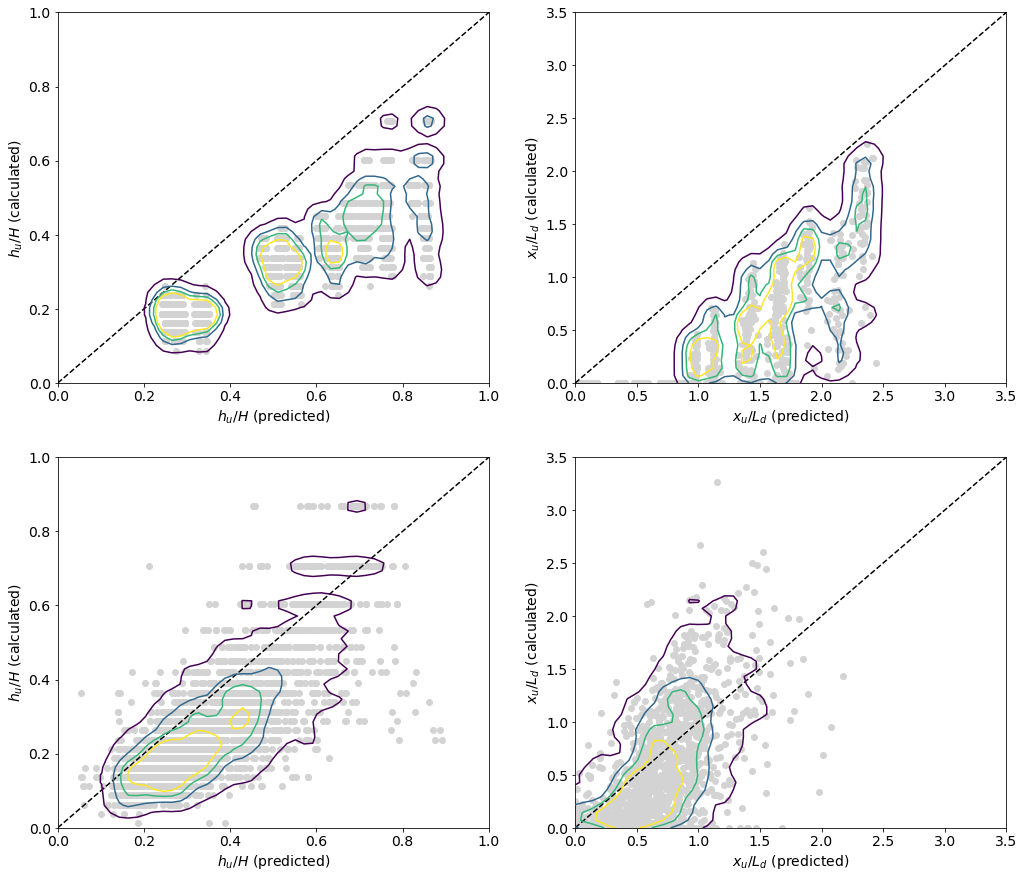

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(17, 15))

n, lim = 50, 1
levels, bandwidth = np.array([1, 4, 7, 10]), 0.02

for row, runs in zip(axs, [runs_idealized, runs_hindcast]):

    for ax, key, norm, lim, label in zip(row, ['h_u', 'x_u'], [const['H'], runs['L_d']], [1, 3.5], ['$h_u/H$', '$x_u/L_d$']):
        
        # Plot data
        x, y = runs[key+'_pred']/norm, runs[key]/norm
        ax.plot(x, y, 'o', color='lightgray')
        
        # Plot KDE
        index = (runs[key] > 0) & ~np.isnan(runs[key+'_pred'])
        grid = np.linspace(0, lim, n)
        xy_data = np.vstack([x[index], y[index]]).T
        xy_grid = np.vstack([dim.ravel() for dim in np.meshgrid(grid, grid)]).T
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth*lim)
        z = np.exp(kde.fit(xy_data).score_samples(xy_grid)).reshape((n, n))
        ax.contour(grid, grid, z, levels=levels/lim**2, zorder=10)
        
        # Formatting
        ax.plot([0, lim], [0, lim], 'k--')
        ax.set_xlim([0, lim])
        ax.set_ylim([0, lim])
        ax.set_xlabel(label + ' (predicted)')
        ax.set_ylabel(label + ' (calculated)')

### Theoretical property-space curves

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


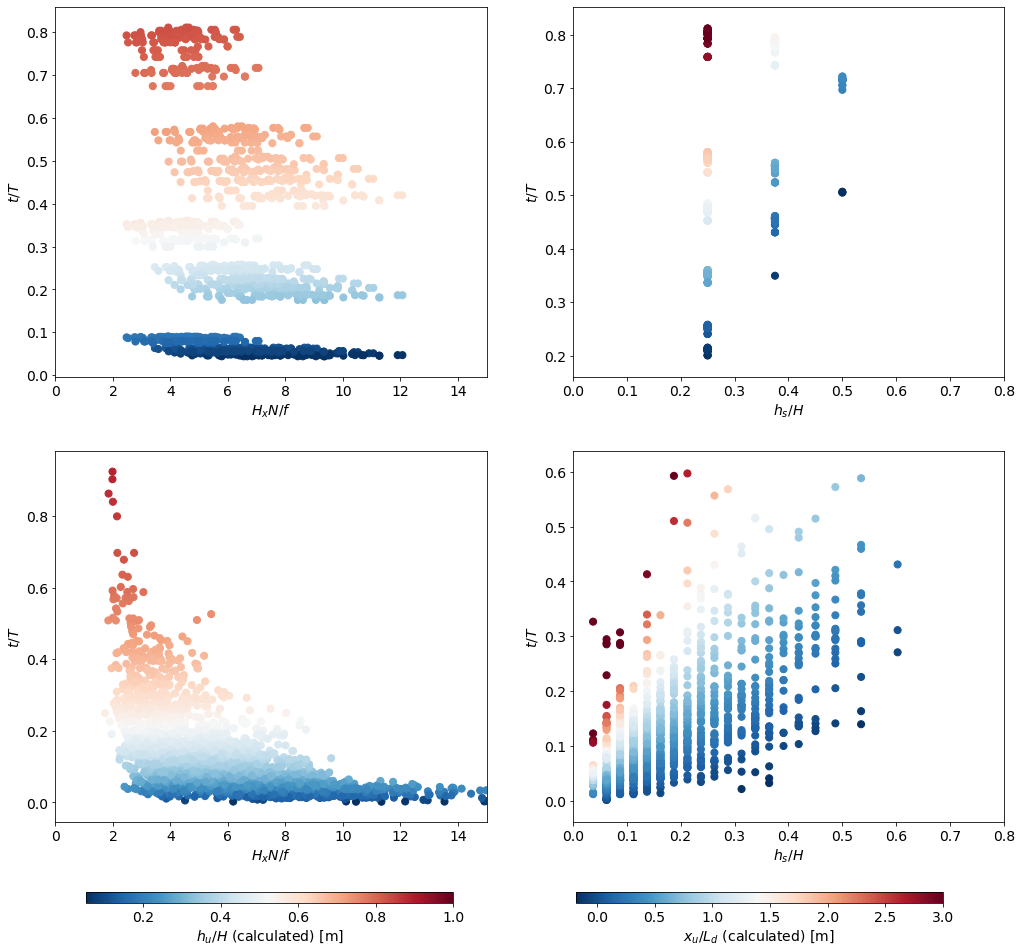

In [241]:
fig, axs = plt.subplots(2, 2, figsize=(17, 15))
cmap = plt.get_cmap('RdBu_r')

for n, row, runs in zip(range(2), axs, [runs_idealized, runs_hindcast]):
    
    predictions = calc_predictions(runs)

    for ax, x, key, norm, xlabel, clabel, xpos, xmax, vmax in zip(row, [predictions['S'], runs['h_s']/const['H']], ['h_u', 'x_u'], [runs['h_s'], predictions['L_d']], ['$H_xN/f$', '$h_s/H$'], ['$h_u/H$', '$x_u/L_d$'], [0.15, 0.55], [15, 0.8], [1, 3]):
        index = (runs[key] > 0) & ~np.isnan(predictions[key])
        
        x, y, z = x[index], (const['t']/predictions['T_d'])[index], (predictions[key])[index]
        c = ax.scatter(x, y, s=50, c=z, cmap=cmap, vmax=vmax)
        
        ax.set_xlim([0, xmax])
        ax.set_xlabel(xlabel)
        ax.set_ylabel('$t/T$')
        if n==1:
            cax = fig.add_axes([xpos, 0.05, 0.3, 0.01])
            fig.colorbar(c, cax=cax, orientation='horizontal', label=clabel + ' (calculated) [m]')

### Upwelling vs Burger number

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


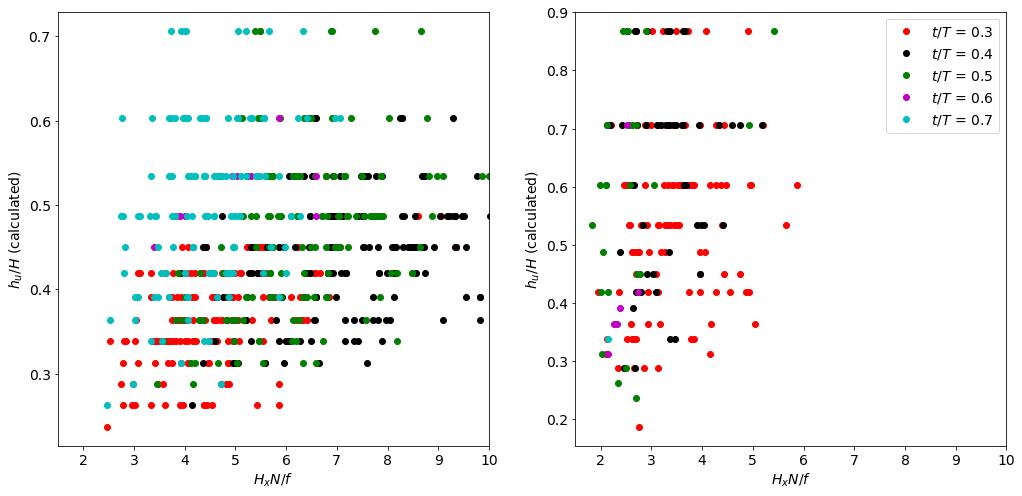

In [281]:
fig, axs = plt.subplots(1, 2, figsize=(17, 8))
cmap = plt.get_cmap('RdBu_r')

for ax, runs in zip(axs, [runs_idealized, runs_hindcast]):
    
    predictions = calc_predictions(runs)
    
    S, tT = predictions['S'], const['t']/predictions['T_d']
    
    for tlim, color in zip([0.3, 0.4, 0.5, 0.6, 0.7], ['r', 'k', 'g', 'm', 'c']):
        
        index = (tT > tlim) & (tT < tlim + 0.1)
        ax.plot(S[index], (runs['h_u']/const['H'])[index], 'o', color=color, label=f'$t/T$ = {tlim}')

    ax.set_xlim([1.5, 10])
    ax.set_xlabel('$H_xN/f$')
    ax.set_ylabel('$h_u/H$ (calculated)')
axs[1].legend()

***

### Alongshore variability (2 layer only)

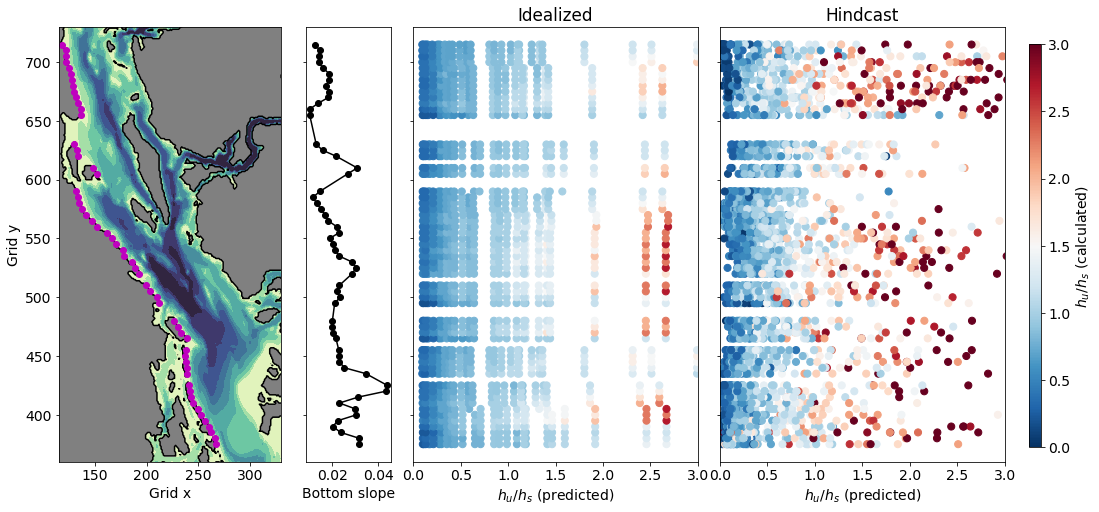

In [72]:
# Make figure panels
fig, axs = plt.subplots(1, 4, figsize=(17, 8), gridspec_kw={'width_ratios': [0.8, 0.3, 1, 1], 'wspace': 0.1})

# Plot map and bathymetry
axs[0].contourf(mask_arrays['tmask'][0, ...], levels=[-0.01, 0.01], colors='gray')
axs[0].contour(mask_arrays['tmask'][0, ...], levels=[-0.01, 0.01], colors='k')
axs[0].contourf(bathy.Bathymetry, levels=range(0, 500, 50), cmap=cm.deep)
axs[0].plot(*sections['ji'][::-1], 'mo')
axs[0].set_xlim([115, 330])
axs[0].set_ylim([360, 730])
axs[0].set_xlabel('Grid x')
axs[0].set_ylabel('Grid y')
viz_tools.set_aspect(axs[0])

# Plot bottom slope
axs[1].plot(sections['slope'], sections['ji'][0], 'ko-')
axs[1].set_ylim([0, 0.05])
axs[1].set_ylim([360, 730])
axs[1].set_xlabel('Bottom slope')
axs[1].yaxis.set_ticklabels('')

# Plot upwelling diagnostics
for ax, runs, title in zip(axs[2:], [runs_idealized, runs_hindcast], ['Idealized', 'Hindcast']):
    if 'tau_along' in runs: tau = runs['tau_along']
    else: tau = runs_wind['tau_along']
    c_s = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s'])
    hu_s = tau * const['t'] / (const['rho_0'] * c_s * runs['h_s'])
    c = ax.scatter(hu_s, runs['j'], s=50, c=runs['h_u'] / runs['h_s'], vmin=0, vmax=3, cmap='RdBu_r')
    ax.set_xlim([0, 3])
    ax.set_ylim([360, 730])
    ax.set_xlabel('$h_u/h_s$ (predicted)')
    ax.set_title(title)
    ax.yaxis.set_ticklabels('')

# Add colorbar
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$h_u/h_s$ (calculated)')
plt.show()

***

### Slope dependence (2 layer only)

Scatter plot by Burger number

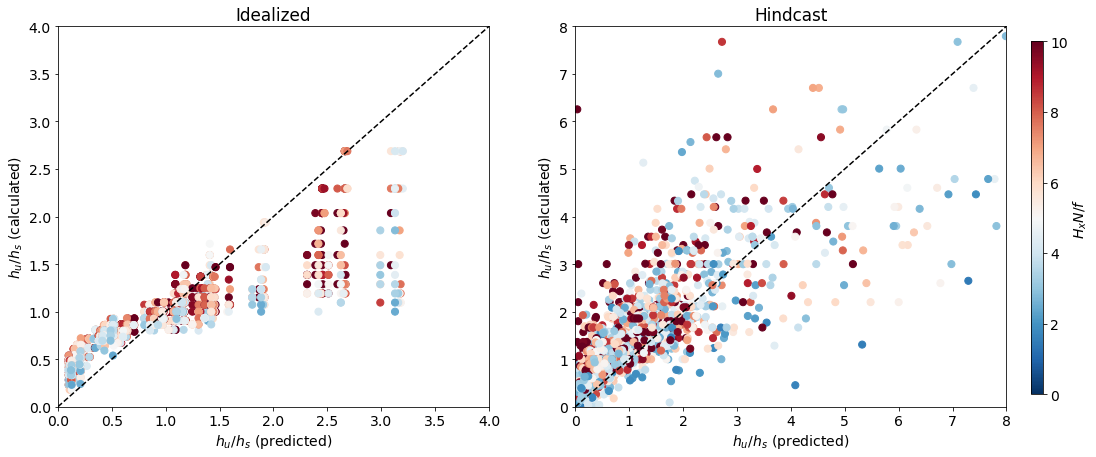

In [87]:
# Make panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

# Plot upwelling diagnostics
for ax, runs, title, lim in zip(axs, [runs_idealized, runs_hindcast], ['Idealized', 'Hindcast'], [4, 8]):
    if 'tau_along' in runs: tau = runs['tau_along']
    else: tau = runs_wind['tau_along']

    # Calculate surface metrics
    c_s = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s'])
    hu_s = tau * const['t'] / (const['rho_0'] * c_s * runs['h_s'])
    S = runs['slope'] * runs['N'] / const['f']

    # Plot results
    c = ax.scatter(hu_s, runs['h_u']/runs['h_s'], s=50, c=S, cmap='RdBu_r', vmin=0, vmax=10)

    # Formatting
    ax.plot([0, lim], [0, lim], 'k--')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_xlabel('$h_u/h_s$ (predicted)')
    ax.set_ylabel('$h_u/h_s$ (calculated)')
    ax.set_title(title)
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$H_xN/f$')
plt.show()

Bin by Burger number

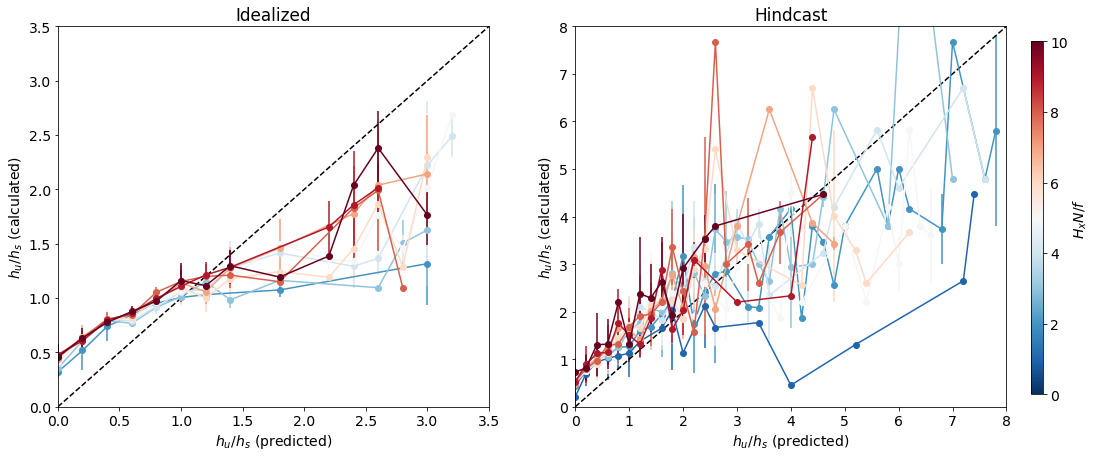

In [116]:
# Make panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cmap = plt.get_cmap('RdBu_r')

# Plot upwelling diagnostics
for ax, runs, title, lim in zip(axs, [runs_idealized, runs_hindcast], ['Idealized', 'Hindcast'], [3.5, 8]):
    if 'tau_along' in runs: tau = runs['tau_along']
    else: tau = runs_wind['tau_along']

    # Calculate surface metrics
    c_s = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s'])
    hu_s = tau * const['t'] / (const['rho_0'] * c_s * runs['h_s'])
    S = runs['slope'] * runs['N'] / const['f']

    # Plot results
    for s in range(0, 11, 1):
        hu, mean, std = [], [], []
        for h in np.arange(0, lim, 0.2):
            
            index = (S > s) & (S < s + 1) & (hu_s > h) & (hu_s < h + 0.2)
            if any(index):
                hu.append(h)
                mean.append((runs['h_u']/runs['h_s'])[index].mean())
                std.append((runs['h_u']/runs['h_s'])[index].std())
        
        ax.errorbar(hu, mean, yerr=std, marker='o', color=cmap(s/10))

    # Formatting
    ax.plot([0, lim], [0, lim], 'k--')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_xlabel('$h_u/h_s$ (predicted)')
    ax.set_ylabel('$h_u/h_s$ (calculated)')
    ax.set_title(title)
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=10), cmap=cmap), cax=cax, label='$H_xN/f$')
plt.show()